In [11]:
%reset -f

# Load libraries and packages

In [12]:
import numpy as np
import random
import torch
import os
from transformers import Adafactor
import pandas as pd
import pdb
from datasets import load_from_disk, load_metric, load_dataset
from transformers import (
    AutoTokenizer,
    get_linear_schedule_with_warmup,
    get_constant_schedule_with_warmup,
    LEDConfig,
    LEDForConditionalGeneration,
)
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torch.utils.data import DataLoader, Dataset
import torch
from argparse import Namespace
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
# Derandomizing cell
random_seed=2024
pl.seed_everything(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

Seed set to 2024


# Data Loader

In [13]:
class SummarizationDataset(Dataset):
    def __init__(
            self,
            hf_dataset,
            tokenizer,
            max_input_len,
            max_output_len,
            mask_num=0,
            dataset_type="train"):

        self.hf_dataset = hf_dataset
        self.tokenizer = tokenizer
        self.max_input_len = max_input_len
        self.max_output_len = max_output_len
        self.docsep_token_id = self.tokenizer.additional_special_tokens_ids[0]
        self.ent_start_id = self.tokenizer.additional_special_tokens_ids[1]
        self.ent_end_id = self.tokenizer.additional_special_tokens_ids[2]
        self.mask_id = self.tokenizer.mask_token_id
        self.mask_num = mask_num
        self.dataset_type = dataset_type

    def check_ent_mismatch(self, input_ids):
        input_ids = torch.tensor(input_ids)
        start = input_ids == self.ent_start_id
        end = input_ids == self.ent_end_id
        input_ids = input_ids.tolist()

        if start.sum() != end.sum():
            if input_ids[-1] == self.tokenizer.eos_token_id:
                input_ids = input_ids[:-1] + [self.ent_end_id] + \
                    [self.tokenizer.eos_token_id]
            else:
                input_ids = input_ids + [self.ent_end_id]
        input_ids = torch.tensor(input_ids)
        start = input_ids == self.ent_start_id
        end = input_ids == self.ent_end_id

        assert start.sum() == end.sum(), "ent token mismatched"

        return input_ids.tolist()

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        entry = self.hf_dataset[idx]
        all_docs = entry["abstract"]
        for i, doc in enumerate(all_docs):
            doc = doc.replace("\n", " ")
            doc = " ".join(doc.split())
            all_docs[i] = doc
        tgt = entry["target"]

        mask_num = self.mask_num

        input_ids = [self.mask_id] * mask_num if mask_num > 0 else []
        for doc in all_docs:
            input_ids.extend(
                self.check_ent_mismatch(self.tokenizer.encode(
                    doc,
                    truncation=True,
                    max_length=(self.max_input_len -
                                mask_num) // len(all_docs),
                )[1:-1])
            )
            input_ids.append(self.docsep_token_id)
        input_ids = (
            [self.tokenizer.bos_token_id]
            + input_ids
            + [self.tokenizer.eos_token_id]
        )

        output_ids = self.check_ent_mismatch(self.tokenizer.encode(
            tgt, truncation=True, max_length=self.max_output_len
        ))

        if self.tokenizer.bos_token_id is None:  # pegasus
            output_ids = [self.tokenizer.pad_token_id] + output_ids
        if self.dataset_type == "train":
            return torch.tensor(input_ids), torch.tensor(output_ids)
        else:
            return torch.tensor(input_ids), torch.tensor(output_ids), tgt


def collate_fn(batch):
    # To know if this is bart or pegasus
    if batch[0][0][-1].item() == 2:
        pad_token_id = (
            # AutoTokenizer.from_pretrained('facebook/bart-base').pad_token_id
            1
        )
    elif batch[0][0][-1].item() == 1:
        pad_token_id = (
            # AutoTokenizer.from_pretrained('google/pegasus-large').pad_token_id
            0
        )
    else:
        assert False
    train = True
    if len(batch[0]) == 3:
        train = False
        tgt = [item[2] for item in batch]
        batch = [item[:2] for item in batch]
    input_ids, output_ids = list(zip(*batch))
    input_ids = torch.nn.utils.rnn.pad_sequence(
        input_ids, batch_first=True, padding_value=pad_token_id
    )
    output_ids = torch.nn.utils.rnn.pad_sequence(
        output_ids, batch_first=True, padding_value=pad_token_id
    )
    if train:
        return input_ids, output_ids
    else:
        return input_ids, output_ids, tgt


def get_dataloader_summ(
    args, hf_dataset, tokenizer, is_train, dataset_type
):
    dataset = SummarizationDataset(
        hf_dataset=hf_dataset,
        tokenizer=tokenizer,
        max_input_len=args.max_length_input,
        max_output_len=args.max_length_tgt,
        mask_num=args.mask_num,
        dataset_type=dataset_type
    )

    return DataLoader(
        dataset,
        batch_size=args.batch_size,
        shuffle=is_train,
        collate_fn=collate_fn,
    )

In [73]:
# Load datasets
train_dataset = load_from_disk('./ms2/train_pio.hf')
train_dataset = train_dataset.shuffle(seed=random_seed)
train_dataset = train_dataset.select(range(220))
val_dataset = load_from_disk('./ms2/val_pio.hf')
val_dataset = val_dataset.shuffle(seed=random_seed)
val_dataset = val_dataset.select(range(30))

# Model

In [14]:
class PRIMERASummariser(pl.LightningModule):
    def __init__(self, args):
        super(PRIMERASummariser, self).__init__()
        self.args = args

        self.tokenizer = AutoTokenizer.from_pretrained(
            self.args.primera_path)

        # Add entity tokens
        self.tokenizer.add_special_tokens({'additional_special_tokens': ["<ent>", "</ent>"]},replace_additional_special_tokens=False)
        self.ent_start_id, self.ent_end_id = self.tokenizer.convert_tokens_to_ids(["<ent>", "</ent>"])
        self.docsep_token_id = self.tokenizer.additional_special_tokens_ids[0]

        self.model = LEDForConditionalGeneration.from_pretrained(
            self.args.primera_path)
        self.model.resize_token_embeddings(len(self.tokenizer))
        self.config = LEDConfig.from_pretrained(self.args.primera_path)
        self.model.gradient_checkpointing_enable()
        self.pad_token_id = self.tokenizer.pad_token_id
        
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def label_smoothed_nll_loss(self, lprobs, target, epsilon, ignore_index=-100):
        """From fairseq"""
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        nll_loss = -lprobs.gather(dim=-1, index=target)
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if ignore_index is not None:
            pad_mask = target.eq(ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
            count = (~pad_mask).sum()
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
            count = nll_loss.numel()

        nll_loss = nll_loss.sum() / count
        smooth_loss = smooth_loss.sum() / count
        eps_i = epsilon / lprobs.size(-1)
        loss = (1.0 - epsilon) * nll_loss + eps_i * smooth_loss

        return loss, nll_loss

    def forward(self, input_ids, output_ids):
        decoder_input_ids = output_ids[:, :-1]

        # Get the input ids and attention masks together
        global_attention_mask = torch.zeros_like(input_ids)

        # Put global attention on <s> token
        global_attention_mask[:, 0] = 1

        # Put global attention on <doc-sep> token
        global_attention_mask[input_ids == self.docsep_token_id] = 1
        
        # Put global attention on <ent> and </ent> tokens
        if self.args.global_attention_mode == "entmarkers":
            global_attention_mask[input_ids == self.ent_start_id] = 1
            global_attention_mask[input_ids == self.ent_end_id] = 1
        
        # Put global attention in between <ent> and </ent> tokens
        elif self.args.global_attention_mode == "entspans":
            start = input_ids == self.ent_start_id
            start_indices = start.nonzero()
            end = input_ids == self.ent_end_id
            end_indices = end.nonzero()

            input_ids[input_ids == self.ent_start_id] = self.pad_token_id
            input_ids[input_ids == self.ent_end_id] = self.pad_token_id

            for s, e in zip(start_indices, end_indices):  
                mask = torch.arange(s[1]+1, e[1])
                global_attention_mask[s[0], mask] = 1
        else:
            print("Global attention mode is incorrect.")
            
        outputs = self.model(
            input_ids,
            decoder_input_ids=decoder_input_ids,
            global_attention_mask=global_attention_mask,
            use_cache=False,
        )
        lm_logits = outputs[0]
        assert lm_logits.shape[-1] == self.model.config.vocab_size
        return lm_logits

    def shared_step(self, input_ids, output_ids):
        lm_logits = self.forward(input_ids, output_ids)
        labels = output_ids[:, 1:].clone()

        lprobs = torch.nn.functional.log_softmax(lm_logits, dim=-1)
        loss, _ = self.label_smoothed_nll_loss(
            lprobs,
            labels,
            self.args.label_smoothing,
            ignore_index=self.pad_token_id,
        )
        if torch.isnan(loss):
            pdb.set_trace()
        return loss

    def training_step(self, batch, batch_idx):
        input_ids, output_ids = batch
        train_loss = self.shared_step(input_ids, output_ids)

        lr = train_loss.new_zeros(
            1) + self.trainer.optimizers[0].param_groups[0]["lr"]

        logs = {
            "train/loss": train_loss,
            "lr": lr,
            "input_size": input_ids.numel(),
            "output_size": output_ids.numel(),
        }
        self.logger.log_metrics(logs, step=self.global_step)

        return train_loss

    def compute_rouge_batch(self, input_ids, output_ids, gold_str):
        scorer = load_metric("rouge")

        # Get the input ids and attention masks together
        global_attention_mask = torch.zeros_like(input_ids)

        # Put global attention on <s> token
        global_attention_mask[:, 0] = 1

        # Put global attention on <doc-sep> token
        global_attention_mask[input_ids == self.docsep_token_id] = 1

        # Put global attention on <ent> and </ent> tokens
        if self.args.global_attention_mode == "entmarkers":
            global_attention_mask[input_ids == self.ent_start_id] = 1
            global_attention_mask[input_ids == self.ent_end_id] = 1
        
        # Put global attention in between <ent> and </ent> tokens
        elif self.args.global_attention_mode == "entspans":
            start = input_ids == self.ent_start_id
            start_indices = start.nonzero()
            end = input_ids == self.ent_end_id
            end_indices = end.nonzero()

            input_ids[input_ids == self.ent_start_id] = self.pad_token_id
            input_ids[input_ids == self.ent_end_id] = self.pad_token_id

            for s, e in zip(start_indices, end_indices):  
                mask = torch.arange(s[1]+1, e[1])
                global_attention_mask[s[0], mask] = 1
        else:
            print("Global attention mode is incorrect.")

        generated_ids = self.model.generate(
            input_ids=input_ids,
            global_attention_mask=global_attention_mask,
            use_cache=True,
            max_length=self.args.max_length_tgt,
            min_length=self.args.min_length_tgt,
            num_beams=self.args.beam_size,
            no_repeat_ngram_size=3 if self.args.applyTriblck else None,
            length_penalty=self.args.length_penalty,
        )

        generated_str = self.tokenizer.batch_decode(
            generated_ids.tolist(), skip_special_tokens=True
        )

        if self.args.mode == "test":
            if self.args.applyTriblck:
                output_dir = os.path.join(
                    self.args.model_path,
                    self.args.mode,
                    "generated_txt_%d_triblck_beam=%d_%d_%d"
                    % (
                        self.args.mask_num,
                        self.args.beam_size,
                        self.args.max_length_input,
                        self.args.max_length_tgt,
                    ),
                )
            else:
                output_dir = os.path.join(
                    self.args.model_path,
                    self.args.mode,
                    "generated_txt_%d_beam=%d_%d_%d"
                    % (
                        self.args.mask_num,
                        self.args.beam_size,
                        self.args.max_length_input,
                        self.args.max_length_tgt,
                    ),
                )
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            idx = len(os.listdir(output_dir))
            # idx = 0
        result_batch = []

        for ref, pred in zip(gold_str, generated_str):
            # change <n> to \n
            pred = pred.replace("<n>", "\n")
            pred = pred.replace(" .", ".").replace(" ,", ",")
            pred = " ".join(pred.split())

            if self.args.mode == "test":
                with open(os.path.join(output_dir, "%d.txt" % (idx)), "w", encoding="utf-8") as of:
                    of.write(pred)
                idx += 1

            s = scorer.compute(
                predictions=[pred],
                references=[ref],
                use_aggregator=False,
                use_stemmer=True,
            )
            result_batch.append(
                (
                    s["rouge1"][0].fmeasure,
                    s["rouge2"][0].fmeasure,
                    s["rougeL"][0].fmeasure,
                )
            )

        return result_batch

    def validation_step(self, batch, batch_idx):
        for p in self.model.parameters():
            p.requires_grad = False
        input_ids, output_ids, tgt = batch
        val_loss = self.shared_step(input_ids, output_ids)

        result_batch = self.compute_rouge_batch(input_ids, output_ids, tgt)
        self.validation_step_outputs.append(
            {'val/loss': val_loss, 'rouge_result': result_batch})
        return {"val/loss": val_loss, "rouge_result": result_batch}

    def compute_rouge_all(self, outputs, output_file=None):
        rouge_result_all = [r for b in outputs for r in b["rouge_result"]]
        names = []
        for rouge in ["1", "2", "L"]:
            names.extend(
                [
                    "rouge-{}-f".format(rouge),
                ]
            )
        rouge_results = pd.DataFrame(rouge_result_all, columns=names)
        avg = [rouge_results[c].mean() for c in rouge_results.columns]
        rouge_results.loc["avg_score"] = avg
        if output_file:
            csv_name = (
                self.args.model_path
                + output_file
                + "-%d-%d.csv"
                % (self.global_step, self.current_epoch)
            )
            rouge_results.to_csv(csv_name)

        avgr = (avg[0] + avg[1] + avg[2]) / 3
        metrics = avg
        print("Validation Result at Step %d" % (self.global_step))
        print("ROUGE-1 F1:", metrics[0])
        print("ROUGE-2 F1:", metrics[1])
        print("ROUGE-L F1:", metrics[2])

        return names, metrics, avgr

    def on_validation_epoch_end(self):
        for p in self.model.parameters():
            p.requires_grad = True

        val_loss = torch.stack([x["val/loss"]
                                for x in self.validation_step_outputs]).mean()
        self.log("val/loss", val_loss)

        names, metrics, avgr = self.compute_rouge_all(
            self.validation_step_outputs, output_file="valid")
        metrics = [val_loss, avgr] + metrics
        names = ["val/loss", "avgr"] + names
        logs = dict(zip(*[names, metrics]))
        self.logger.log_metrics(logs, step=self.global_step)
        self.log("avgr", avgr)
        self.validation_step_outputs.clear()  # free memory

        return {
            "avg_val_loss": val_loss,
            "avgr": avgr,
            "log": logs,
            "progress_bar": logs,
        }

    def test_step(self, batch, batch_idx):
        for p in self.model.parameters():
            p.requires_grad = False
        input_ids, output_ids, tgt = batch
        test_loss = self.shared_step(input_ids, output_ids)

        result_batch = self.compute_rouge_batch(input_ids, output_ids, tgt)
        self.test_step_outputs.append(
            {'test/loss': test_loss, 'rouge_result': result_batch})

        return {"test/loss": test_loss, "rouge_result": result_batch}

    def on_test_epoch_end(self):
        test_loss = torch.stack([x["test/loss"]
                                 for x in self.test_step_outputs]).mean()
        self.log('test/loss', test_loss)
        output_file = "test_%d_%d_beam=%d_lenPen=%.2f" % (
            self.args.max_length_input,
            self.args.max_length_tgt,
            self.args.beam_size,
            self.args.length_penalty,
        )

        names, metrics, avgr = self.compute_rouge_all(
            self.test_step_outputs, output_file=output_file)
        self.test_step_outputs.clear()  # free memory
        metrics = [test_loss, avgr] + metrics
        names = ["test/loss", "avgr"] + names
        logs = dict(zip(*[names, metrics]))
        self.logger.log_metrics(logs, step=self.global_step)
        self.log("avgr", avgr)
        return {"avg_test_loss": test_loss, "avgr": avgr, "log": logs, "progress_bar": logs}

    def configure_optimizers(self):
        if self.args.optimizer == 'adafactor':
            optimizer = Adafactor(
                self.parameters(),
                lr=self.args.lr,
                scale_parameter=False,
                relative_step=False,
            )
            scheduler = get_constant_schedule_with_warmup(
                optimizer, num_warmup_steps=self.args.warmup_steps
            )
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=self.args.lr)
            scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps=self.args.warmup_steps,
                num_training_steps=self.args.total_steps,
            )
        return [optimizer], [{"scheduler": scheduler, "interval": "step"}]

# Train

In [37]:
def train(config, model, train_dataloader, valid_dataloader):
    if not os.path.exists(config.model_path):
        os.makedirs(config.model_path)

    # Construct the LightningModule
    # model = PRIMERASummariser(config)
    print(model.tokenizer)
    print(model.tokenizer.additional_special_tokens_ids[0], 
          model.tokenizer.additional_special_tokens_ids[1],
          model.tokenizer.additional_special_tokens_ids[2])
    print(model.tokenizer.convert_ids_to_tokens([model.tokenizer.additional_special_tokens_ids[0], 
                                                 model.tokenizer.additional_special_tokens_ids[1], 
                                                 model.tokenizer.additional_special_tokens_ids[2]]))
    
    # Initialize logger
    logger = TensorBoardLogger(config.model_path + "tb_logs", name=config.model_name)

    # Initialize checkpoint
    if config.ckpt_path is None:
        config.ckpt_path = config.model_path + "checkpoints/"

    checkpoint_callback = ModelCheckpoint(
        dirpath=config.ckpt_path,
        filename="epoch={epoch}-step={step}-vloss={val/loss:.3f}-tloss={train/loss:.3f}-avgr={avgr:.3f}",
        auto_insert_metric_name=False,
        save_top_k=config.saveTopK,
        monitor="val/loss",
        mode="min",
        save_on_train_epoch_end=False,
    )

    early_stopping_callback = EarlyStopping(
        monitor="val/loss", mode="min", min_delta=0.00, patience=3,
        verbose=False, check_on_train_epoch_end=False)

    # Initialize trainer
    trainer = pl.Trainer(
        max_steps=config.total_steps,
        max_epochs=config.max_epochs,
        accumulate_grad_batches=config.acc_batch,
        check_val_every_n_epoch=1,
        logger=logger,
        log_every_n_steps=5,
        callbacks=[checkpoint_callback, early_stopping_callback],
        enable_checkpointing=True,
        enable_progress_bar=True,
        precision=32,
        accelerator="cpu",
        deterministic=True,
    )

    if config.resume_ckpt is not None:
        trainer.fit(model, train_dataloader, valid_dataloader,
                    ckpt_path=config.ckpt_path)
    else:
        trainer.fit(model, train_dataloader, valid_dataloader)

## EntMarkers

In [30]:
args = Namespace(
        global_attention_mode="entmarkers",
        mode="train",
        model_name="entmarkers",
        primera_path="allenai/PRIMERA-multixscience",
        model_path="./models/absummed_em/",
        ckpt_path="./models/absummed_em/checkpoints",
        saveTopK=-1,
        resume_ckpt=None,  # None or True or Path
        batch_size=2,
        max_length_input=4096,  # Max length 4096
        max_length_tgt=512,  # Max length 1024
        min_length_tgt=0,
        label_smoothing=0.1,
        optimizer='adam',  # Use adam/adafactor optimizer
        rand_seed=2024,
        lr=1e-5,
        warmup_steps=110,  # 10% of total_steps 110
        total_steps=1100,  # (num_train_epochs * train_data) / batch_size 1100
        max_epochs=10,
        acc_batch=5,
        beam_size=2,
        length_penalty=1,
        mask_num=0,
        test_batch_size=1,
        applyTriblck=False,  # Apply trigram block in the evaluation phase
        )

In [31]:
em_model = PRIMERASummariser(args)
train_dataloader = get_dataloader_summ(
    args, train_dataset, em_model.tokenizer, True, "train")

valid_dataloader = get_dataloader_summ(
    args, val_dataset, em_model.tokenizer, False, "validation")

In [ ]:
train(args, em_model, train_dataloader, valid_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./models/absummed/tb_logs\entmarkers


LEDTokenizerFast(name_or_path='allenai/PRIMERA-multixscience', vocab_size=50265, model_max_length=4096, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>', 'additional_special_tokens': ['<doc-sep>', '<ent>', '</ent>']}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
	50265: AddedToken("<doc-sep


  | Name  | Type                        | Params
------------------------------------------------------
0 | model | LEDForConditionalGeneration | 447 M 
------------------------------------------------------
447 M     Trainable params
0         Non-trainable params
447 M     Total params
1,788.887 Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\absummed\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
Input ids are automatically padded from 4078 to 4096 to be a multiple of `config.attention_window`: 512
C:\Users\User\AppData\Local\Temp\ipykernel_20192\3864794150.py:123: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  scorer = load_metric("rouge")
c:\Users\User\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:753: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/d

Validation Result at Step 0
ROUGE-1 F1: 0.03438721000450545
ROUGE-2 F1: 0.005799523437270228
ROUGE-L F1: 0.027090861798491246


c:\Users\User\anaconda3\envs\absummed\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Input ids are automatically padded from 3983 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 4018 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 4034 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3935 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3264 to 3584 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 4066 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 4026 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 4077 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 4060 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 4016 to 4096 to be a mul

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:753: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
c:\Users\User\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:753: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to loa

Validation Result at Step 22
ROUGE-1 F1: 0.04294508262691151
ROUGE-2 F1: 0.002794182371004206
ROUGE-L F1: 0.037283399855432234


Input ids are automatically padded from 3758 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3972 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3949 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3971 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 4043 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3468 to 3584 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3630 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3852 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3678 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3968 to 4096 to be a mul

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:753: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
c:\Users\User\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:753: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to loa

Validation Result at Step 44
ROUGE-1 F1: 0.14518669395633918
ROUGE-2 F1: 0.024158715229111043
ROUGE-L F1: 0.10702946430148264


Input ids are automatically padded from 3719 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3045 to 3072 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3426 to 3584 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3943 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3247 to 3584 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3739 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3793 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3536 to 3584 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3365 to 3584 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3531 to 3584 to be a mul

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:753: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
c:\Users\User\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:753: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to loa

Validation Result at Step 66
ROUGE-1 F1: 0.1680414431816217
ROUGE-2 F1: 0.024019138312677435
ROUGE-L F1: 0.12852447475250828


Input ids are automatically padded from 3629 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3889 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 1782 to 2048 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3419 to 3584 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3519 to 3584 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3775 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3827 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 2163 to 2560 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3451 to 3584 to be a multiple of `config.attention_window`: 512


Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:753: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
c:\Users\User\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:753: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to loa

Validation Result at Step 88
ROUGE-1 F1: 0.17580327827839973
ROUGE-2 F1: 0.027756662590149275
ROUGE-L F1: 0.13673764950076636


Input ids are automatically padded from 2998 to 3072 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3984 to 4096 to be a multiple of `config.attention_window`: 512


Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:753: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
c:\Users\User\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:753: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to loa

Validation Result at Step 110
ROUGE-1 F1: 0.167354250378113
ROUGE-2 F1: 0.03155836095661613
ROUGE-L F1: 0.1364479833889077


Input ids are automatically padded from 3014 to 3072 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 1715 to 2048 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3204 to 3584 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3999 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 1829 to 2048 to be a multiple of `config.attention_window`: 512


Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:753: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
c:\Users\User\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:753: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to loa

Validation Result at Step 132
ROUGE-1 F1: 0.18389607113505438
ROUGE-2 F1: 0.030885854889949483
ROUGE-L F1: 0.14019112276969187


Input ids are automatically padded from 3235 to 3584 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 2102 to 2560 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3781 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3307 to 3584 to be a multiple of `config.attention_window`: 512


Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:753: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
c:\Users\User\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:753: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to loa

Validation Result at Step 154
ROUGE-1 F1: 0.20737343610111064
ROUGE-2 F1: 0.035221444137847634
ROUGE-L F1: 0.15498336289398643


Input ids are automatically padded from 3931 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 2906 to 3072 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3575 to 3584 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 1704 to 2048 to be a multiple of `config.attention_window`: 512


Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:753: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
c:\Users\User\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:753: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to loa

Validation Result at Step 176
ROUGE-1 F1: 0.18625351136606028
ROUGE-2 F1: 0.031860759712875844
ROUGE-L F1: 0.14725848756398155


Input ids are automatically padded from 3899 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 2024 to 2048 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 2859 to 3072 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3672 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3788 to 4096 to be a multiple of `config.attention_window`: 512


Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:753: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
c:\Users\User\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:753: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to loa

Validation Result at Step 198
ROUGE-1 F1: 0.16381005578789126
ROUGE-2 F1: 0.019968397857564997
ROUGE-L F1: 0.12763561227073605


Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:753: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
c:\Users\User\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:753: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to loa

Validation Result at Step 220
ROUGE-1 F1: 0.16382410186029134
ROUGE-2 F1: 0.013962428358389884
ROUGE-L F1: 0.12832594214773443


`Trainer.fit` stopped: `max_epochs=10` reached.


## EntSpans

In [6]:
args = Namespace(
        global_attention_mode="entspans",
        mode="train",
        model_name="entspans",
        primera_path="allenai/PRIMERA-multixscience",
        model_path="./models/absummed_es/",
        ckpt_path="./models/absummed_es/checkpoints",
        saveTopK=-1,
        resume_ckpt=None,  # None or True or Path
        batch_size=2,
        max_length_input=4096,  # Max length 4096
        max_length_tgt=512,  # Max length 1024
        min_length_tgt=0,
        label_smoothing=0.1,
        optimizer='adam',  # Use adam/adafactor optimizer
        rand_seed=2024,
        lr=1e-5,
        warmup_steps=110,  # 10% of total_steps 110
        total_steps=1100,  # (num_train_epochs * train_data) / batch_size 1100
        max_epochs=10,
        acc_batch=5,
        beam_size=2,
        length_penalty=1,
        mask_num=0,
        test_batch_size=1,
        applyTriblck=False,  # Apply trigram block in the evaluation phase
        )

In [39]:
es_model = PRIMERASummariser(args)
train_dataloader = get_dataloader_summ(
    args, train_dataset, es_model.tokenizer, True, "train")

valid_dataloader = get_dataloader_summ(
    args, val_dataset, es_model.tokenizer, False, "validation")

In [40]:
train(args, es_model, train_dataloader, valid_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./models/absummed/tb_logs\entspans

  | Name  | Type                        | Params
------------------------------------------------------
0 | model | LEDForConditionalGeneration | 447 M 
------------------------------------------------------
447 M     Trainable params
0         Non-trainable params
447 M     Total params
1,788.887 Total estimated model params size (MB)


LEDTokenizerFast(name_or_path='allenai/PRIMERA-multixscience', vocab_size=50265, model_max_length=4096, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>', 'additional_special_tokens': ['<doc-sep>', '<ent>', '</ent>']}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
	50265: AddedToken("<doc-sep

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\ellae\anaconda3\envs\absummed\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\ellae\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:752: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
c:\Users\ellae\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:752: FutureWarning: The repository for rouge contains custom code which

Validation Result at Step 0
ROUGE-1 F1: 0.16123987950910995
ROUGE-2 F1: 0.025337031566063102
ROUGE-L F1: 0.11338817353468819


c:\Users\ellae\anaconda3\envs\absummed\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Input ids are automatically padded from 3983 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 4018 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 4034 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3935 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3264 to 3584 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 4066 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 4026 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 4077 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 4060 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 4016 to 4096 to be a mul

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\ellae\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:752: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
c:\Users\ellae\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:752: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to l

Validation Result at Step 22
ROUGE-1 F1: 0.15205484878809158
ROUGE-2 F1: 0.02778754628657627
ROUGE-L F1: 0.1130231219111456


Input ids are automatically padded from 3758 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3972 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3949 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3971 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 4043 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3468 to 3584 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3630 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3852 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3678 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3968 to 4096 to be a mul

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\ellae\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:752: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
c:\Users\ellae\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:752: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to l

Validation Result at Step 44
ROUGE-1 F1: 0.18448309079663008
ROUGE-2 F1: 0.025222013605384754
ROUGE-L F1: 0.1260290520476633


Input ids are automatically padded from 3719 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3045 to 3072 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3426 to 3584 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3943 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3247 to 3584 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3739 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3793 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3536 to 3584 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3365 to 3584 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3531 to 3584 to be a mul

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\ellae\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:752: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
c:\Users\ellae\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:752: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to l

Validation Result at Step 66
ROUGE-1 F1: 0.18895842083431658
ROUGE-2 F1: 0.027126541243437885
ROUGE-L F1: 0.13068512395008944


Input ids are automatically padded from 3629 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3889 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 1782 to 2048 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3419 to 3584 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3519 to 3584 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3775 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3827 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 2163 to 2560 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3451 to 3584 to be a multiple of `config.attention_window`: 512


Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\ellae\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:752: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
c:\Users\ellae\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:752: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to l

Validation Result at Step 88
ROUGE-1 F1: 0.19892352594735715
ROUGE-2 F1: 0.03444715312188751
ROUGE-L F1: 0.1496067996653706


Input ids are automatically padded from 2998 to 3072 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3984 to 4096 to be a multiple of `config.attention_window`: 512


Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\ellae\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:752: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
c:\Users\ellae\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:752: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to l

Validation Result at Step 110
ROUGE-1 F1: 0.20706243558300924
ROUGE-2 F1: 0.02794298159491302
ROUGE-L F1: 0.15615181317417262


Input ids are automatically padded from 3014 to 3072 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 1715 to 2048 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3204 to 3584 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3999 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 1829 to 2048 to be a multiple of `config.attention_window`: 512


Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\ellae\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:752: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
c:\Users\ellae\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:752: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to l

Validation Result at Step 132
ROUGE-1 F1: 0.20880548632188217
ROUGE-2 F1: 0.035467859294256505
ROUGE-L F1: 0.15301053896240277


Input ids are automatically padded from 3235 to 3584 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 2102 to 2560 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3781 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3307 to 3584 to be a multiple of `config.attention_window`: 512


Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\ellae\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:752: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
c:\Users\ellae\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:752: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to l

Validation Result at Step 154
ROUGE-1 F1: 0.19365263274276176
ROUGE-2 F1: 0.031113238138906756
ROUGE-L F1: 0.1482146905610119


Input ids are automatically padded from 3931 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 2906 to 3072 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3575 to 3584 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 1704 to 2048 to be a multiple of `config.attention_window`: 512


Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\ellae\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:752: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
c:\Users\ellae\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:752: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to l

Validation Result at Step 176
ROUGE-1 F1: 0.17799308062369887
ROUGE-2 F1: 0.021592102301815526
ROUGE-L F1: 0.13196127306677866


Input ids are automatically padded from 3899 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 2024 to 2048 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 2859 to 3072 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3672 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3788 to 4096 to be a multiple of `config.attention_window`: 512


Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\ellae\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:752: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
c:\Users\ellae\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:752: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to l

Validation Result at Step 198
ROUGE-1 F1: 0.1975582742104686
ROUGE-2 F1: 0.034225729599306524
ROUGE-L F1: 0.15139851180944405


Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\ellae\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:752: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
c:\Users\ellae\anaconda3\envs\absummed\Lib\site-packages\datasets\load.py:752: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to l

Validation Result at Step 220
ROUGE-1 F1: 0.20759550391060827
ROUGE-2 F1: 0.032365252545348513
ROUGE-L F1: 0.16102268042474996


`Trainer.fit` stopped: `max_epochs=10` reached.


## Validation

In [47]:
# Function to extract data from TensorBoard log file
def extract_data(log_path, tag):
    data = []
    for e in tf.data.TFRecordDataset(log_path):
        event = tf.compat.v1.Event.FromString(e.numpy())
        for v in event.summary.value:
            if v.tag == tag:
                data.append((event.step, v.simple_value))
    return data

In [53]:
def extract_metrics_at_step(log_path, tag_train_loss, tag_val_loss, tag_rouge, step):
    train_loss = None
    val_loss = None
    avg_rouge = None

    data = extract_data(log_path, tag_train_loss)
    for step_value_pair in data:
        if step_value_pair[0] == step:
            train_loss = step_value_pair[1]
            break

    data = extract_data(log_path, tag_val_loss)
    for step_value_pair in data:
        if step_value_pair[0] == step:
            val_loss = step_value_pair[1]
            break

    data = extract_data(log_path, tag_rouge)
    for step_value_pair in data:
        if step_value_pair[0] == step:
            avg_rouge = step_value_pair[1]
            break

    return train_loss, val_loss, avg_rouge

### EntMarkers

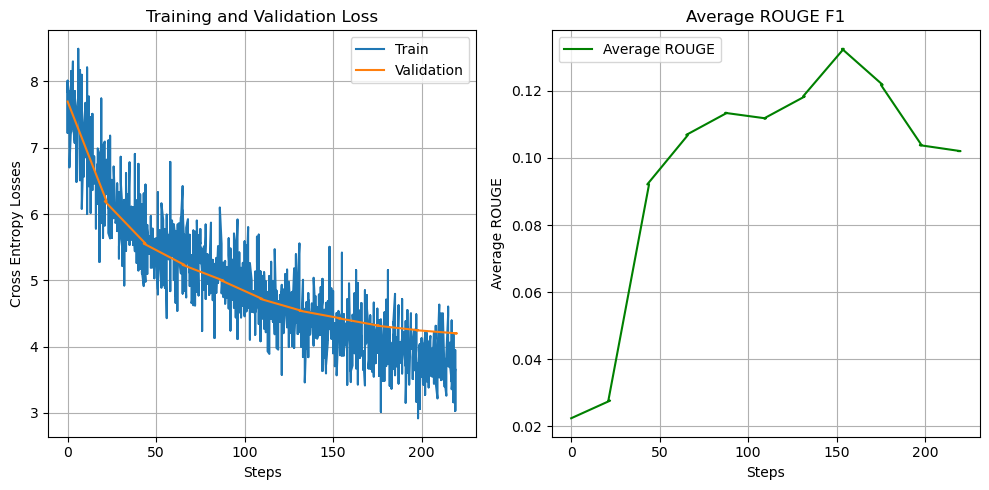

In [48]:
log_path = "./models/absummed_em/tb_logs/entmarkers/version_0/events.out.tfevents.1709181575.DESKTOP-16TP510"

# Extract training and validation loss, and average ROUGE from the log file
train_loss_data = extract_data(log_path, 'train/loss')
val_loss_data = extract_data(log_path, 'val/loss')
avgr_data = extract_data(log_path, 'avgr')

# Plot the data
train_steps, train_loss = zip(*train_loss_data)
val_steps, val_loss = zip(*val_loss_data)
avgr_steps, avgr = zip(*avgr_data)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_steps, train_loss, label='Train')
plt.plot(val_steps, val_loss, label='Validation')
plt.xlabel('Steps')
plt.ylabel('Cross Entropy Losses')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(avgr_steps, avgr, label='Average ROUGE', color='green')
plt.xlabel('Steps')
plt.ylabel('Average ROUGE')
plt.title('Average ROUGE F1')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [62]:
model_tloss, model_vloss, model_avgr = extract_metrics_at_step(log_path, 'train/loss', 'val/loss', 'avgr', 153)
print(f"Train Loss: {model_tloss:.3f}\nValidation Loss: {model_vloss:.3f}\nAverage ROUGE: {model_avgr:.3f}")

Train Loss: 4.221
Validation Loss: 4.428
Average ROUGE: 0.133


In [38]:
# Comparison of summary generated between absummed_es1 and absummed_es2
# Summarise function in Test section

# Validation data
summary_em1 = summarise(val_dataset['abstract'][0], absummed_em1)
summary_em2 = summarise(val_dataset['abstract'][0], absummed_em2)

In [44]:
print(f"Target summary:\n{val_dataset['target'][0]}\n")
print(f"Summary generated by AbSumMed-EM1:\n{summary_em1}\n")
print(f"Summary generated by AbSumMed-EM2: \n{summary_em2}\n")

Target summary:
in brief , <ent>female atrial fibrillation patients</ent> more commonly present comorbidities , leading to a higher prevalence of persistent atrial fibrillation <ent>;</ent> moreover , they refer to hospital care later and with a longer disease history .
atrial fibrillation symptoms relate to low quality of life in <ent>female patients</ent> ; in fact , atrial fibrillation paroxysm usually presents higher heart rate , leading to preferentially adopt a rate rather than a rhythm-control strategy .
<ent>female atrial fibrillation patients</ent> present an increased risk of stroke , worsened by the lower  oral anticoagulant prescription rate related to the concomitant higher haemorrhagic risk profile .
<ent>trans</ent>-catheter ablation is under-used in <ent>female patients</ent> and , on the contrary , they are more commonly affected by anti-arrhythmic drug side effects

Summary generated by AbSumMed-EM1:
conclusions the results suggest that adverse events are more common 

### EntSpans

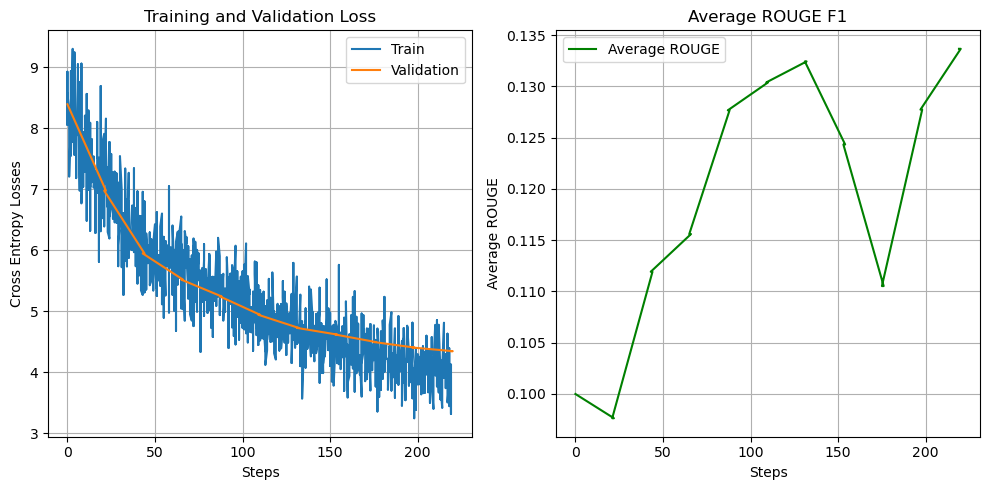

In [11]:
log_path = "./models/absummed_es/tb_logs/entspans/version_0/events.out.tfevents.1709216988.7thMay"

# Extract training and validation loss, and average ROUGE from the log file
train_loss_data = extract_data(log_path, 'train/loss')
val_loss_data = extract_data(log_path, 'val/loss')
avgr_data = extract_data(log_path, 'avgr')

# Plot the data
train_steps, train_loss = zip(*train_loss_data)
val_steps, val_loss = zip(*val_loss_data)
avgr_steps, avgr = zip(*avgr_data)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_steps, train_loss, label='Train')
plt.plot(val_steps, val_loss, label='Validation')
plt.xlabel('Steps')
plt.ylabel('Cross Entropy Losses')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(avgr_steps, avgr, label='Average ROUGE', color='green')
plt.xlabel('Steps')
plt.ylabel('Average ROUGE')
plt.title('Average ROUGE F1')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [78]:
model_tloss, model_vloss, model_avgr = extract_metrics_at_step(log_path, 'train/loss', 'val/loss', 'avgr', 219)
print(f"Train Loss: {model_tloss:.3f}\nValidation Loss: {model_vloss:.3f}\nAverage ROUGE: {model_avgr:.3f}")

Train Loss: 3.321
Validation Loss: 4.345
Average ROUGE: 0.134


In [17]:
# Comparison of summary generated between absummed_es1 and absummed_es2
# Summarise function in Test section

# Validation data
summary_es1 = summarise(val_dataset['abstract'][0], absummed_es1)
summary_es2 = summarise(val_dataset['abstract'][0], absummed_es2)

Input ids are automatically padded from 4071 to 4096 to be a multiple of `config.attention_window`: 512


In [19]:
print(f"Target summary:\n{val_dataset['target'][0]}\n")
print(f"Summary generated by AbSumMed-ES1:\n{summary_es1}\n")
print(f"Summary generated by AbSumMed-ES2: \n{summary_es2}\n")

Target summary:
in brief , <ent>female atrial fibrillation patients</ent> more commonly present comorbidities , leading to a higher prevalence of persistent atrial fibrillation <ent>;</ent> moreover , they refer to hospital care later and with a longer disease history .
atrial fibrillation symptoms relate to low quality of life in <ent>female patients</ent> ; in fact , atrial fibrillation paroxysm usually presents higher heart rate , leading to preferentially adopt a rate rather than a rhythm-control strategy .
<ent>female atrial fibrillation patients</ent> present an increased risk of stroke , worsened by the lower  oral anticoagulant prescription rate related to the concomitant higher haemorrhagic risk profile .
<ent>trans</ent>-catheter ablation is under-used in <ent>female patients</ent> and , on the contrary , they are more commonly affected by anti-arrhythmic drug side effects

Summary generated by AbSumMed-ES1:
conclusions atrial fibrillation ( af ) is associated with an increas

# Test

## Prepare for testing

In [ ]:
test = load_dataset("allenai/mslr2022", "ms2", split="validation")

In [ ]:
def lowercase(dataset):
    dataset['abstract'] = [study.lower() for study in dataset['abstract']]
    dataset['target'] = dataset['target'].lower()
    return dataset

def remove_duplicates(dataset):
    unique_abstracts = set()
    unique_targets = set()

    # Create a new list to store the cleaned data
    cleaned_data = []

    for row in dataset:
        # Extract 'abstract' and 'target' from the row
        abstract = row['abstract']
        target = row['target']

        # Convert the abstract to a frozenset
        abstract_frozenset = frozenset(abstract)

        # Check if this frozenset is unique
        if abstract_frozenset not in unique_abstracts and target not in unique_targets:
            # If unique, append the row to the cleaned data
            cleaned_data.append(row)

            # Add the frozenset and target to the sets of unique values
            unique_abstracts.add(abstract_frozenset)
            unique_targets.add(target)

    # Convert the cleaned data back to a Dataset
    cleaned_dataset = Dataset.from_dict({key: [row[key] for row in cleaned_data] for key in dataset.column_names})

    return cleaned_dataset

test = test.remove_columns(['pmid', 'title'])
test = test.map(lowercase)
test = remove_duplicates(test)
test.save_to_disk("./ms2/test.hf") # with abstract

Saving the dataset (0/1 shards):   0%|          | 0/2014 [00:00<?, ? examples/s]

In [ ]:
test = load_from_disk("./ms2/test.hf")

In [ ]:
test

Dataset({
    features: ['ReviewID', 'Target', 'Background'],
    num_rows: 2014
})

In [ ]:
test = test.remove_columns(['abstract'])

In [ ]:
# Rename columns
test = test.rename_column("review_id", "ReviewID")
test = test.rename_column("target", "Target")
test = test.rename_column("background", "Background")

sampled_test = test.shuffle(seed=random_seed).select(range(30))

In [ ]:
# Export the dataset to CSV
test.to_csv("./outputs/test-targets.csv") # without abstract for automatic evaluation purposes
sampled_test.to_csv("./outputs/sampled-test-targets.csv") # without abstract for automatic evaluation purposes

Creating CSV from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

24105

## Best Model Summary Generation

### AbSumMed-ES

In [7]:
args = Namespace(
        global_attention_mode="entspans", # entspans / entmarkers
        mode="test",
        model_name="entspans", # entspans / entmarkers
        primera_path="allenai/PRIMERA-multixscience",
        model_path="./models/absummed_es/",
        ckpt_path="./models/absummed_es/checkpoints",
        saveTopK=-1,
        resume_ckpt=None,  # None or True or Path
        batch_size=2,
        max_length_input=4096,  # Max length 4096
        max_length_tgt=512,  # Max length 1024
        min_length_tgt=0,
        label_smoothing=0.1,
        optimizer='adam',  # Use adam/adafactor optimizer
        rand_seed=2024,
        lr=1e-5,
        warmup_steps=110,  # 10% of total_steps 110
        total_steps=1100,  # (num_train_epochs * train_data) / batch_size 1100
        max_epochs=10,
        acc_batch=5,
        beam_size=2,
        length_penalty=1,
        mask_num=0,
        test_batch_size=1,
        applyTriblck=False,  # Apply trigram block in the evaluation phase
        )

# path1 = './models/absummed_es/checkpoints/epoch=5-step=132-vloss=4.727-tloss=0.000-avgr=0.132.ckpt'
path2 = './models/absummed_es/checkpoints/epoch=9-step=220-vloss=4.345-tloss=0.000-avgr=0.134.ckpt'
# absummed_es1 = PRIMERASummariser.load_from_checkpoint(checkpoint_path=path1, args=args)
# absummed_es1.freeze()
absummed_es2 = PRIMERASummariser.load_from_checkpoint(checkpoint_path=path2, args=args)
absummed_es2.freeze()

In [8]:
# print(absummed_es1.tokenizer.convert_ids_to_tokens(absummed_es1.tokenizer.additional_special_tokens_ids[0]))
# print(absummed_es1.tokenizer.convert_ids_to_tokens(absummed_es1.tokenizer.additional_special_tokens_ids[1]))
# print(absummed_es1.tokenizer.convert_ids_to_tokens(absummed_es1.tokenizer.additional_special_tokens_ids[2]))
print(absummed_es2.tokenizer.convert_ids_to_tokens(absummed_es2.tokenizer.additional_special_tokens_ids[0]))
print(absummed_es2.tokenizer.convert_ids_to_tokens(absummed_es2.tokenizer.additional_special_tokens_ids[1]))
print(absummed_es2.tokenizer.convert_ids_to_tokens(absummed_es2.tokenizer.additional_special_tokens_ids[2]))

<doc-sep>
<ent>
</ent>


In [9]:
def check_ent_mismatch(input_ids, model):
    input_ids = torch.tensor(input_ids)
    start = input_ids == model.tokenizer.additional_special_tokens_ids[1]
    end = input_ids == model.tokenizer.additional_special_tokens_ids[2]
    input_ids = input_ids.tolist()

    if start.sum() != end.sum():
        if input_ids[-1] == model.tokenizer.eos_token_id:
            input_ids = input_ids[:-1] + [model.tokenizer.additional_special_tokens_ids[2]] + \
                [model.tokenizer.eos_token_id]
        else:
            input_ids = input_ids + [model.tokenizer.additional_special_tokens_ids[2]]
    input_ids = torch.tensor(input_ids)
    start = input_ids == model.tokenizer.additional_special_tokens_ids[1]
    end = input_ids == model.tokenizer.additional_special_tokens_ids[2]

    assert start.sum() == end.sum(), "ent token mismatched"

    return input_ids.tolist()

def summarise(docs, model):
    input_ids = []
    for doc in docs:
        input_ids.extend(
            check_ent_mismatch(model.tokenizer.encode(
                doc,
                truncation=True,
                max_length=4096 // len(docs),
            )[1:-1], model)
        )
        input_ids.append(model.tokenizer.additional_special_tokens_ids[0])

    input_ids = [model.tokenizer.bos_token_id] + input_ids + [model.tokenizer.eos_token_id]

    # Convert input_ids to tensor
    input_tensor = torch.tensor(input_ids).unsqueeze(0)

    global_attention_mask = torch.zeros_like(input_tensor)
    global_attention_mask[:, 0] = 1
    global_attention_mask[input_tensor == model.tokenizer.additional_special_tokens_ids[0]] = 1

    # Entity markers
    # global_attention_mask[input_tensor == model.tokenizer.additional_special_tokens_ids[1]] = 1
    # global_attention_mask[input_tensor == model.tokenizer.additional_special_tokens_ids[2]] = 1

    # Entity spans
    start = input_tensor == model.tokenizer.additional_special_tokens_ids[1]
    start_indices = start.nonzero()
    end = input_tensor == model.tokenizer.additional_special_tokens_ids[2]
    end_indices = end.nonzero()

    input_tensor[input_tensor == model.tokenizer.additional_special_tokens_ids[1]] = model.tokenizer.pad_token_id
    input_tensor[input_tensor == model.tokenizer.additional_special_tokens_ids[2]] = model.tokenizer.pad_token_id

    for s, e in zip(start_indices, end_indices):
        mask = torch.arange(s[1]+1, e[1])
        global_attention_mask[s[0], mask] = 1

    summarised_ids = model.model.generate(
        input_ids=input_tensor,
        global_attention_mask=global_attention_mask,
        use_cache=True,
        max_length=512,
        min_length=0,
        num_beams=2,
        length_penalty=1,
    )

    generated_str = model.tokenizer.batch_decode(summarised_ids.tolist(), skip_special_tokens=True)
    generated_str = " ".join(generated_str)
    summary = generated_str.replace("<n>", "\n")
    summary = summary.replace(" .", ".").replace(" ,", ",")
    summary = " ".join(summary.split())

    return summary


In [114]:
# Load test set
full_test = load_from_disk("./ms2/val_pio.hf")
review_id = load_from_disk("./ms2/test.hf")
sampled_test = full_test.shuffle(seed=random_seed)
sampled_test = sampled_test.select(range(30))
sampled_id = review_id.shuffle(seed=random_seed)
sampled_id = sampled_id.select(range(30))

In [119]:
summaries = []

# Iterate through all abstracts and generate summaries
for abstract in full_test['abstract']:
    summary = summarise(abstract, absummed_es2)
    summaries.append(summary)

Input ids are automatically padded from 1631 to 2048 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 4082 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 4088 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 4069 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3674 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 4011 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3993 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 4078 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3976 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 4081 to 4096 to be a mul

In [120]:
# Create a DataFrame with the review ID and their corresponding summaries
full_df = pd.DataFrame()
full_df['ReviewID'] = review_id['review_id']
full_df['Generated'] = summaries

# Write the DataFrame to a CSV file
full_df.to_csv('./outputs/absummed_es/test-predictions.csv')

In [125]:
full_df

,ReviewID,Generated
0,28514886,the results of this review indicate that prebi...
1,18842808,the results of this review indicate that gluco...
2,24297836,conclusions : although a history of ams is hig...
3,32367221,there was no significant difference in grade o...
4,25038833,there was no significant association between a...
...,...,...
2009,19776504,the results of this review indicate that resin...
2010,27505198,"however, there was no evidence of a significan..."
2011,25251296,results the results of this review suggest tha...
2012,23235652,the current evidence suggests that zinc is ben...


In [128]:
sampled_summaries = []

# Iterate through all abstracts and generate summaries
for abstract in sampled_test['abstract']:
    summary = summarise(abstract, absummed_es2)
    sampled_summaries.append(summary)

In [129]:
# Create a DataFrame with the review ID and their corresponding summaries
sampled_df = pd.DataFrame()
sampled_df['ReviewID'] = sampled_id['review_id']
sampled_df['Generated'] = sampled_summaries

sampled_df.to_csv('./outputs/absummed_es/sampled-test-predictions.csv')

In [130]:
sampled_df

,ReviewID,Generated
0,25806470,the results of this review suggest that atrial...
1,23001018,we found no evidence of a significant differen...
2,25879093,there is limited evidence to support the use o...
3,29767225,the results of this review indicate that physi...
4,28827256,the results of this review indicate that dysfu...
5,19776504,the results of this review indicate that resin...
6,29320437,we found no evidence of a significant associat...
7,24752440,the results of this review indicate that exerc...
8,19160249,there was no evidence to support the effective...
9,29728079,the results of this review suggest that there ...


### AbSumMed-EM

In [ ]:
args = Namespace(
        global_attention_mode="entmarkers", # entspans / entmarkers
        mode="test",
        model_name="entmarkers", # entspans / entmarkers
        primera_path="allenai/PRIMERA-multixscience",
        model_path="./models/absummed_em/",
        ckpt_path="./models/absummed_em/checkpoints",
        saveTopK=-1,
        resume_ckpt=None,  # None or True or Path
        batch_size=2,
        max_length_input=4096,  # Max length 4096
        max_length_tgt=512,  # Max length 1024
        min_length_tgt=0,
        label_smoothing=0.1,
        optimizer='adam',  # Use adam/adafactor optimizer
        rand_seed=2024,
        lr=1e-5,
        warmup_steps=110,  # 10% of total_steps 110
        total_steps=1100,  # (num_train_epochs * train_data) / batch_size 1100
        max_epochs=10,
        acc_batch=5,
        beam_size=2,
        length_penalty=1,
        mask_num=0,
        test_batch_size=1,
        applyTriblck=False,  # Apply trigram block in the evaluation phase
        )

path1 = './models/absummed_em/checkpoints/epoch=6-step=154-vloss=4.428-tloss=0.000-avgr=0.133.ckpt'
# path2 = './models/absummed_em/checkpoints/epoch=9-step=220-vloss=4.199-tloss=0.000-avgr=0.102.ckpt'
absummed_em1 = PRIMERASummariser.load_from_checkpoint(checkpoint_path=path1, args=args)
absummed_em1.freeze()
# absummed_em2 = PRIMERASummariser.load_from_checkpoint(checkpoint_path=path2, args=args)
# absummed_em2.freeze()

In [ ]:
print(absummed_em1.tokenizer.convert_ids_to_tokens(absummed_em1.tokenizer.additional_special_tokens_ids[0]))
print(absummed_em1.tokenizer.convert_ids_to_tokens(absummed_em1.tokenizer.additional_special_tokens_ids[1]))
print(absummed_em1.tokenizer.convert_ids_to_tokens(absummed_em1.tokenizer.additional_special_tokens_ids[2]))
# print(absummed_em2.tokenizer.convert_ids_to_tokens(absummed_em2.tokenizer.additional_special_tokens_ids[0]))
# print(absummed_em2.tokenizer.convert_ids_to_tokens(absummed_em2.tokenizer.additional_special_tokens_ids[1]))
# print(absummed_em2.tokenizer.convert_ids_to_tokens(absummed_em2.tokenizer.additional_special_tokens_ids[2]))

<doc-sep>
<ent>
</ent>


In [ ]:
def check_ent_mismatch(input_ids, model):
    input_ids = torch.tensor(input_ids)
    start = input_ids == model.tokenizer.additional_special_tokens_ids[1]
    end = input_ids == model.tokenizer.additional_special_tokens_ids[2]
    input_ids = input_ids.tolist()

    if start.sum() != end.sum():
        if input_ids[-1] == model.tokenizer.eos_token_id:
            input_ids = input_ids[:-1] + [model.tokenizer.additional_special_tokens_ids[2]] + \
                [model.tokenizer.eos_token_id]
        else:
            input_ids = input_ids + [model.tokenizer.additional_special_tokens_ids[2]]
    input_ids = torch.tensor(input_ids)
    start = input_ids == model.tokenizer.additional_special_tokens_ids[1]
    end = input_ids == model.tokenizer.additional_special_tokens_ids[2]

    assert start.sum() == end.sum(), "ent token mismatched"

    return input_ids.tolist()

def summarise(docs, model):
    input_ids = []
    for doc in docs:
        input_ids.extend(
            check_ent_mismatch(model.tokenizer.encode(
                doc,
                truncation=True,
                max_length=4096 // len(docs),
            )[1:-1], model)
        )
        input_ids.append(model.tokenizer.additional_special_tokens_ids[0])

    input_ids = [model.tokenizer.bos_token_id] + input_ids + [model.tokenizer.eos_token_id]

    # Convert input_ids to tensor
    input_tensor = torch.tensor(input_ids).unsqueeze(0)

    global_attention_mask = torch.zeros_like(input_tensor)
    global_attention_mask[:, 0] = 1
    global_attention_mask[input_tensor == model.tokenizer.additional_special_tokens_ids[0]] = 1

    # Entity markers
    global_attention_mask[input_tensor == model.tokenizer.additional_special_tokens_ids[1]] = 1
    global_attention_mask[input_tensor == model.tokenizer.additional_special_tokens_ids[2]] = 1

    # Entity spans
    # start = input_tensor == model.tokenizer.additional_special_tokens_ids[1]
    # start_indices = start.nonzero()
    # end = input_tensor == model.tokenizer.additional_special_tokens_ids[2]
    # end_indices = end.nonzero()

    # input_tensor[input_tensor == model.tokenizer.additional_special_tokens_ids[1]] = model.tokenizer.pad_token_id
    # input_tensor[input_tensor == model.tokenizer.additional_special_tokens_ids[2]] = model.tokenizer.pad_token_id

    # for s, e in zip(start_indices, end_indices):
    #     mask = torch.arange(s[1]+1, e[1])
    #     global_attention_mask[s[0], mask] = 1

    summarised_ids = model.model.generate(
        input_ids=input_tensor,
        global_attention_mask=global_attention_mask,
        use_cache=True,
        max_length=512,
        min_length=0,
        num_beams=2,
        length_penalty=1,
    )

    generated_str = model.tokenizer.batch_decode(summarised_ids.tolist(), skip_special_tokens=True)
    generated_str = " ".join(generated_str)
    summary = generated_str.replace("<n>", "\n")
    summary = summary.replace(" .", ".").replace(" ,", ",")
    summary = " ".join(summary.split())

    return summary


In [ ]:
# Load test set
full_test = load_from_disk("./ms2/val_pio.hf")
review_id = load_from_disk("./ms2/test.hf")
sampled_test = full_test.shuffle(seed=random_seed)
sampled_test = sampled_test.select(range(30))
sampled_id = review_id.shuffle(seed=random_seed)
sampled_id = sampled_id.select(range(30))

In [ ]:
summaries = []

# Iterate through all abstracts and generate summaries
for abstract in full_test['abstract']:
    summary = summarise(abstract, absummed_em1)
    summaries.append(summary)

Input ids are automatically padded from 4083 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3562 to 3584 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 1631 to 2048 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 4082 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 4088 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 4069 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3674 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 4011 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 3993 to 4096 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 4078 to 4096 to be a mul

In [ ]:
# Create a DataFrame with the review ID and their corresponding summaries
full_df = pd.DataFrame()
full_df['ReviewID'] = review_id['review_id']
full_df['Generated'] = summaries

# Write the DataFrame to a CSV file
full_df.to_csv('./outputs/absummed_em/test-predictions.csv')


In [ ]:
full_df

,ReviewID,Generated
0,28514886,conclusions prebiotic oligosaccharides may inc...
1,18842808,the results suggest that glucomannan may be ef...
2,24297836,"conversely, lf(sbp ) was higher in the ams gro..."
3,32367221,conclusions : there is evidence that patellar ...
4,25038833,conclusions : there was no significant associa...
...,...,...
2009,19776504,conclusions the results of this review suggest...
2010,27505198,conclusions the present meta- analysis suggest...
2011,25251296,conclusions the results of this review suggest...
2012,23235652,conclusions : there is evidence that zinc is b...


In [ ]:
sampled_summaries = []

# Iterate through all abstracts and generate summaries
for abstract in sampled_test['abstract']:
    summary = summarise(abstract, absummed_em1)
    sampled_summaries.append(summary)

In [ ]:
# Create a DataFrame with the review ID and their corresponding summaries
sampled_df = pd.DataFrame()
sampled_df['ReviewID'] = sampled_id['review_id']
sampled_df['Generated'] = sampled_summaries

sampled_df.to_csv('./outputs/absummed_em/sampled-test-predictions.csv')

In [ ]:
sampled_df

,ReviewID,Generated
0,25806470,conclusions the results suggest that adverse e...
1,23001018,our results suggest that anticoagulant therapy...
2,25879093,our results suggest that dehydroepi and roster...
3,29767225,conclusions the results of this review suggest...
4,28827256,conclusions the results suggest that family-ba...
5,19776504,conclusions the results of this review suggest...
6,29320437,conclusion : there is evidence to support the ...
7,24752440,"our results suggest that exercise, especially ..."
8,19160249,our results suggest that diabetes education an...
9,29728079,conclusions the present study supports the hyp...


# Inference

In [15]:
data = load_from_disk("./ms2/val_pio.hf")
target = load_from_disk("./ms2/test.hf")

In [16]:
args = Namespace(
        global_attention_mode="entspans", # entspans / entmarkers
        mode="test",
        model_name="entspans", # entspans / entmarkers
        primera_path="allenai/PRIMERA-multixscience",
        model_path="./models/absummed_es/",
        ckpt_path="./models/absummed_es/checkpoints",
        saveTopK=-1,
        resume_ckpt=None,  # None or True or Path
        batch_size=2,
        max_length_input=4096,  # Max length 4096
        max_length_tgt=512,  # Max length 1024
        min_length_tgt=0,
        label_smoothing=0.1,
        optimizer='adam',  # Use adam/adafactor optimizer
        rand_seed=2024,
        lr=1e-5,
        warmup_steps=110,  # 10% of total_steps 110
        total_steps=1100,  # (num_train_epochs * train_data) / batch_size 1100
        max_epochs=10,
        acc_batch=5,
        beam_size=2,
        length_penalty=1,
        mask_num=0,
        test_batch_size=1,
        applyTriblck=False,  # Apply trigram block in the evaluation phase
        )

# path1 = './models/absummed_es/checkpoints/epoch=5-step=132-vloss=4.727-tloss=0.000-avgr=0.132.ckpt'
path2 = './models/absummed_es/checkpoints/epoch=9-step=220-vloss=4.345-tloss=0.000-avgr=0.134.ckpt'
# absummed_es1 = PRIMERASummariser.load_from_checkpoint(checkpoint_path=path1, args=args)
# absummed_es1.freeze()
absummed = PRIMERASummariser.load_from_checkpoint(checkpoint_path=path2, args=args)
absummed.freeze()

In [17]:
def check_ent_mismatch(input_ids, model):
    input_ids = torch.tensor(input_ids)
    start = input_ids == model.tokenizer.additional_special_tokens_ids[1]
    end = input_ids == model.tokenizer.additional_special_tokens_ids[2]
    input_ids = input_ids.tolist()

    if start.sum() != end.sum():
        if input_ids[-1] == model.tokenizer.eos_token_id:
            input_ids = input_ids[:-1] + [model.tokenizer.additional_special_tokens_ids[2]] + \
                [model.tokenizer.eos_token_id]
        else:
            input_ids = input_ids + [model.tokenizer.additional_special_tokens_ids[2]]
    input_ids = torch.tensor(input_ids)
    start = input_ids == model.tokenizer.additional_special_tokens_ids[1]
    end = input_ids == model.tokenizer.additional_special_tokens_ids[2]

    assert start.sum() == end.sum(), "ent token mismatched"

    return input_ids.tolist()

def summarise(docs, model):
    input_ids = []
    for doc in docs:
        input_ids.extend(
            check_ent_mismatch(model.tokenizer.encode(
                doc,
                truncation=True,
                max_length=4096 // len(docs),
            )[1:-1], model)
        )
        input_ids.append(model.tokenizer.additional_special_tokens_ids[0])

    input_ids = [model.tokenizer.bos_token_id] + input_ids + [model.tokenizer.eos_token_id]

    # Convert input_ids to tensor
    input_tensor = torch.tensor(input_ids).unsqueeze(0)

    global_attention_mask = torch.zeros_like(input_tensor)
    global_attention_mask[:, 0] = 1
    global_attention_mask[input_tensor == model.tokenizer.additional_special_tokens_ids[0]] = 1

    # Entity markers
    # global_attention_mask[input_tensor == model.tokenizer.additional_special_tokens_ids[1]] = 1
    # global_attention_mask[input_tensor == model.tokenizer.additional_special_tokens_ids[2]] = 1

    # Entity spans
    start = input_tensor == model.tokenizer.additional_special_tokens_ids[1]
    start_indices = start.nonzero()
    end = input_tensor == model.tokenizer.additional_special_tokens_ids[2]
    end_indices = end.nonzero()

    input_tensor[input_tensor == model.tokenizer.additional_special_tokens_ids[1]] = model.tokenizer.pad_token_id
    input_tensor[input_tensor == model.tokenizer.additional_special_tokens_ids[2]] = model.tokenizer.pad_token_id

    for s, e in zip(start_indices, end_indices):
        mask = torch.arange(s[1]+1, e[1])
        global_attention_mask[s[0], mask] = 1

    summarised_ids = model.model.generate(
        input_ids=input_tensor,
        global_attention_mask=global_attention_mask,
        use_cache=True,
        max_length=512,
        min_length=0,
        num_beams=2,
        length_penalty=1,
    )

    generated_str = model.tokenizer.batch_decode(summarised_ids.tolist(), skip_special_tokens=True)
    generated_str = " ".join(generated_str)
    summary = generated_str.replace("<n>", "\n")
    summary = summary.replace(" .", ".").replace(" ,", ",")
    summary = " ".join(summary.split())

    return summary


In [18]:
docs = data['abstract'][0]

print("Input documents:")
for i, doc in enumerate(docs):
    print(f"[{i+1}] {doc}")

Input documents:
[1] abstract a healthy intestinal microbiota is considered to be important for priming of the infants ' mucosal and systemic immunity . <ent>breast-fed infants</ent> typically have an intestinal microbiota dominated by different bifidobacterium species . it has been described that <ent>allergic infants</ent> have different levels of specific bifidobacterium species than healthy infants . for the accurate quantification of bifidobacterium adolescentis , bifidobacterium angulatum , bifidobacterium bifidum , bifidobacterium breve , bifidobacterium catenulatum , bifidobacterium dentium , bifidobacterium infantis , and bifidobacterium longum in fecal sample s , duplex 5′ nuclease assays were developed . the assays , targeting rrna gene intergenic spacer regions , were vali date d and compared with conventional pcr and fluorescent in situ hybridization methods . the 5′ nuclease assays were subsequently used to determine the relative amounts of different <ent>bifidobacterium 

In [19]:
# Get the target summary and the generated summary
target_summary = target['target'][0]
generated_summary = summarise(docs, absummed)

print("Target Summary:")
print(target_summary)
print("\n" + "="*20 + "\n")
print("Generated Summary:")
print(generated_summary.lower())


Target Summary:
current evidence from systematic review and meta- analysis revealed that probiotics are the most promising intervention in reduction of the incidence of nec in vlbw neonates .
as per the evidence , prebiotics modulate the composition of human intestine microflora to the benefit of the host by suppression of colonization of harmful microorganism and /or the stimulation of bifidobacterial growth , decreased stool viscosity , reduced gastrointestinal transit time , and better feed tolerance .


Generated Summary:
the results of this review indicate that prebiotic supplementation may reduce the incidence of nec in infants.
